

---



**IMPORTS**


---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Dense, RepeatVector, TimeDistributed, LSTM, Embedding, Dropout, Bidirectional



---
**LOADING DATASET**

---





In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp ./drive/MyDrive/en-ru.zip ./
!unzip en-ru.zip

Mounted at /content/drive
Archive:  en-ru.zip
  inflating: en-ru.txt               




---
**READING DATA**


---





In [3]:
def read_text(filename):
    with open (filename, 'r') as f:
        text = f.read()
    return text.split('\n')

In [4]:
text = read_text("en-ru.txt")
text = text[1:20001]

eng, rus = [], []
for i in text:
    __eng, __rus = i.split('\t')
    eng += [__eng]
    rus += [__rus]
    



---


**PRE - PROCESSING**



---



In [5]:
def tokenize(data):
    data_tokenizer = Tokenizer(char_level = False)
    data_tokenizer.fit_on_texts(data)
    return data_tokenizer.texts_to_sequences(data), data_tokenizer

def pad(data, length=None):
    if length is None:
        length = max([len(i) for i in data])
    return pad_sequences(data, maxlen = length, padding = 'post')

def preprocess(data):
    prep_data, data_tokenizer = tokenize(data)
    prep_data = pad(prep_data)

    return prep_data, data_tokenizer

def idx2text(idx, tokenizer):
    idx2word = {id: word for word, id in tokenizer.word_index.items()}
    idx2word[0] = ''

    return ' '.join([idx2word[i] for i in np.argmax(idx, 1)])

In [6]:
eng_s, eng_tok = preprocess(eng)
rus_s, rus_tok = preprocess(rus)
eng_s = eng_s.reshape(*eng_s.shape, 1)



---


**MODEL CREATION**



---



In [7]:
def model(input_shape, output_length, rus_vs):
  
    model = Sequential()

    model.add(Bidirectional(
        LSTM(128, return_sequences = True, dropout = 0.25), 
                           input_shape = input_shape[1:]))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(RepeatVector(output_length))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Dense(rus_vs, activation='softmax')))
    
    model.compile(loss=sparse_categorical_crossentropy, 
                 optimizer=Adam(1e-3), metrics=['accuracy'])
    
    return model



---


**TRAINING**



---



In [8]:
_x = pad(rus_s, eng_s.shape[1])
_x = _x.reshape((-1, eng_s.shape[-2], 1))

model = model(_x.shape, eng_s.shape[1], len(eng_tok.word_index))
model.summary()

hist = model.fit(_x, eng_s, batch_size=35, epochs=10, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 192, 256)          133120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 192, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 192, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 192, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 192, 37205)        4



---


**PLOTS**



---



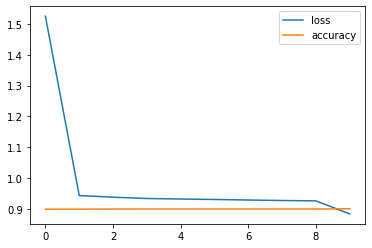

In [9]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.legend(['loss','accuracy'])
plt.show()



---


**EVALUATION**



---



In [11]:
test = read_text('eval-ru-100.txt')
test_s, test_tk = preprocess(test)
test_x = pad(test_s, rus_s.shape[-2])
test_x = test_x.reshape((-1, rus_s.shape[-2], 1))

res = []
for i in range(len(test_x)):
    _r = idx2text(model.predict(test_x[i:i+1])[0], eng_tok)
    res += [_r]
    print(_r)

with open('answer.txt', 'w') as f:
    f.write('\n'.join(res)) 

the                                                                                                                                                                                               
the                                                                                                                                                                                               
the                                                                                                                                                                                               
the                                                                                                                                                                                               
the                                                                                                                                                                                               
the                      

In [12]:
model.save('model.h5')